In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
os.chdir('..')

from models.architectures.encoders.fc import FCEncoder
from models.architectures.decoders.fc import FCDecoder
from models.vae import VAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import numpy as np

In [ ]:
# model parameters
SEED = 50
INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50
# training parameters
BATCH_SIZE = 500
NUM_EPOCHS = 1000
LEARNING_RATE=5e-5
CUDA = torch.cuda.is_available()
parameters = {'SEED':SEED, 'INPUT_DIM':INPUT_DIM, 'HIDDEN_DIM':HIDDEN_DIM, 'LATENT_DIM':LATENT_DIM, 'BATCH_SIZE':BATCH_SIZE,
              'NUM_EPOCHS':NUM_EPOCHS, 'LEARNING_RATE':LEARNING_RATE}
DATA_PATH = 'resources/datasets/20news/'
SAVE_PATH = 'results/nvdm/'

### Data loading

In [2]:
# data loading
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open(DATA_PATH+'topics.json', 'r'))
train_data = np.load(DATA_PATH+'train.npy')
train_labels = np.load(DATA_PATH+'train.labels.npy')
test_data = np.load(DATA_PATH+'test.npy')
test_labels = np.load(DATA_PATH+'test.labels.npy')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, test_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)



### Model training

In [3]:
# model training
enc = FCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, architecture='NVDM')
dec = FCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, architecture='NVDM')
model = VAE(encoder=enc, decoder=dec)
model.cuda().double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, included_labels=True, log_interval=10).run(optimizer, NUM_EPOCHS)
# save parameters
json.dump(parameters, open(SAVE_PATH+'parameters.json', 'w'))

Train Epoch:  1 [     0/ 11314 (  0%)]	Loss: 287.172146
Train Epoch:  1 [  5000/ 11314 ( 43%)]	Loss: 309.026854
Train Epoch:  1 [ 10000/ 11314 ( 87%)]	Loss: 297.190021
====> Epoch: 1 Average loss: 338.3788
====> Test set loss: 308.4141
Train Epoch:  2 [     0/ 11314 (  0%)]	Loss: 256.784423
Train Epoch:  2 [  5000/ 11314 ( 43%)]	Loss: 315.340224
Train Epoch:  2 [ 10000/ 11314 ( 87%)]	Loss: 368.812134
====> Epoch: 2 Average loss: 335.6393
====> Test set loss: 311.6253
Train Epoch:  3 [     0/ 11314 (  0%)]	Loss: 342.118327
Train Epoch:  3 [  5000/ 11314 ( 43%)]	Loss: 327.202892
Train Epoch:  3 [ 10000/ 11314 ( 87%)]	Loss: 319.990494
====> Epoch: 3 Average loss: 333.9684
====> Test set loss: 310.3575
Train Epoch:  4 [     0/ 11314 (  0%)]	Loss: 303.011275
Train Epoch:  4 [  5000/ 11314 ( 43%)]	Loss: 321.239092
Train Epoch:  4 [ 10000/ 11314 ( 87%)]	Loss: 407.822132
====> Epoch: 4 Average loss: 333.8138
====> Test set loss: 314.9170
Train Epoch:  5 [     0/ 11314 (  0%)]	Loss: 380.205797


### Restore model

In [3]:
# EVALUATION
# model loading
enc = FCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, architecture='NVDM')
dec = FCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, architecture='NVDM')
model = VAE(encoder=enc, decoder=dec)
model.load_state_dict(torch.load('results/nvdm/model.pt'))
model.cuda().double()
model.eval()

VAE(
  (encoder): FCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): FCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

### Evaluation

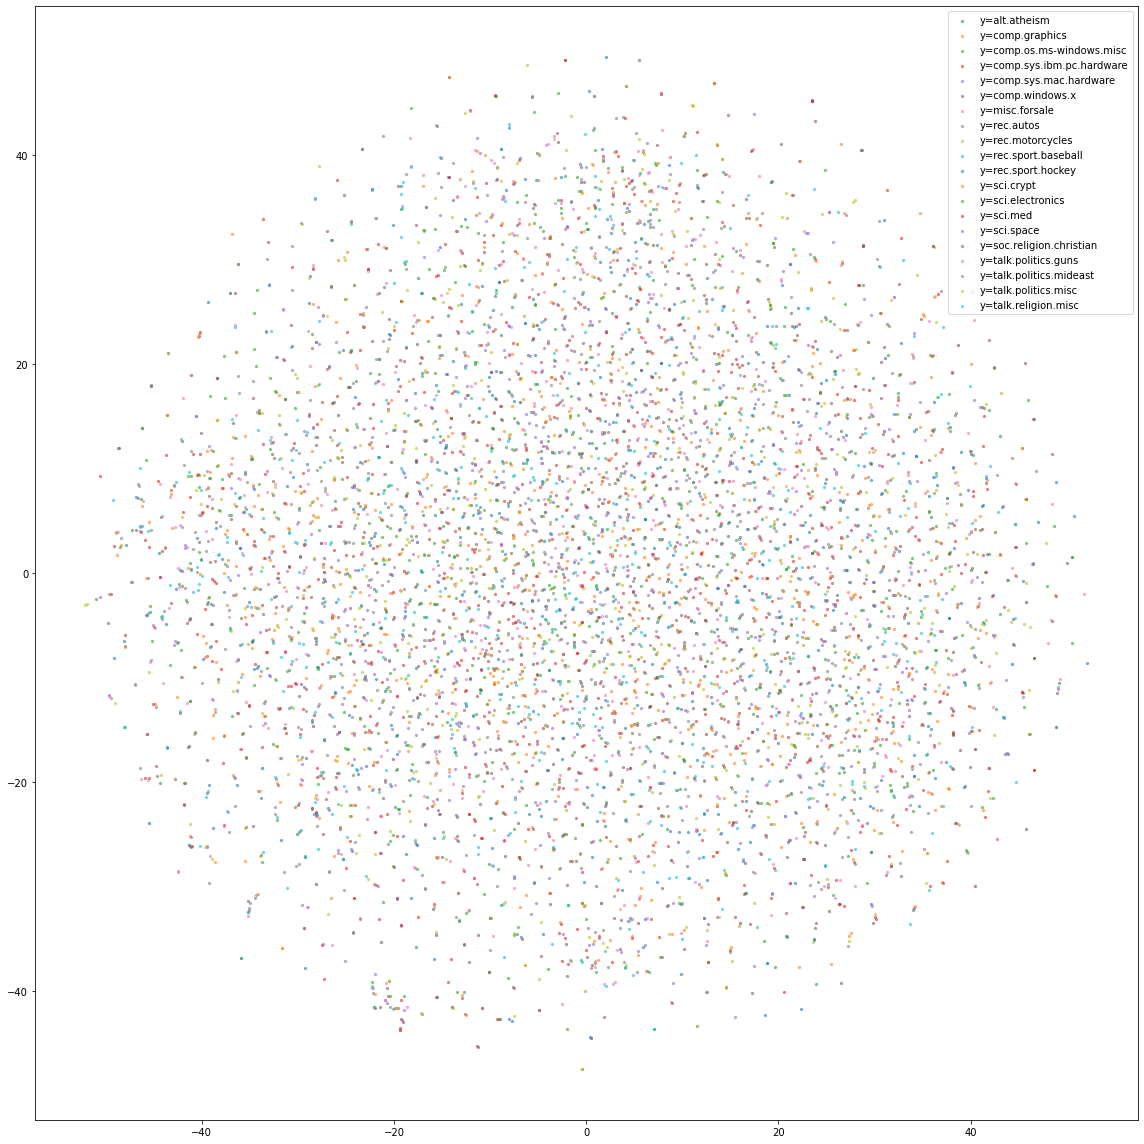

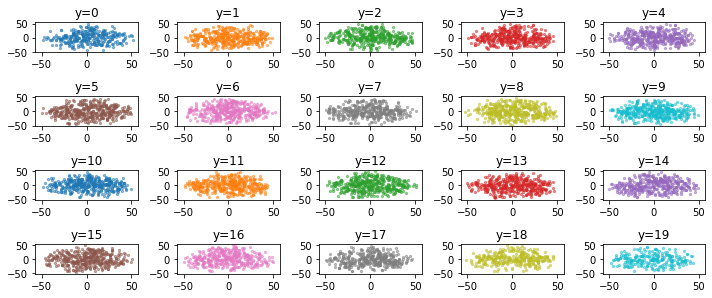

In [28]:
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
from utils.vae_utils import reparametrize
zs = []
z_mus = []
xs = []
ys = []

for (x, y) in test_loader:
    mu, logvar = model.encode(x.cuda().double())
    z = reparametrize(mu, logvar)
    zs.append(z.cpu().detach().numpy())
    z_mus.append(mu.cpu().detach().numpy())
    xs.append(x.numpy())
    ys.append(y.numpy())

zs = np.concatenate(zs, 0)
z_mus = np.concatenate(z_mus, 0)
xs = np.concatenate(xs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
zs2 = TSNE().fit_transform(zs)

fig = plt.figure(figsize=(16,16))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k], alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# for each class independently
fig = plt.figure(figsize=(10,4.25))

for k in range(len(labels)):
    ax = plt.subplot(4,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()

In [4]:
from evaluation.topics import print_top_words
# Top words in topics
# load the vocab
vocab = json.load(open(DATA_PATH+'vocab.json','r'))
idx2word = {i:vocab[i] for i in range(len(vocab))}
# get weights of the decoder
emb = model.decoder.main[0].weight.cpu().detach().numpy().T
print_top_words(emb, idx2word)


--------------- Topics ------------------
man human society anti true rights children christian members live
users package surface bbs release access storage developing private calls
shot penalty victims israeli arab guns citizens muslim muslims peace
evidence men history earth percent jewish christians theory family scientific
work lot people radio things email software read max dont
jewish arabs interpretation paragraph homosexual objects israeli bible existence israel
world nazi europe german play government street countries british put
read video isa ive mode system call put side court
orbit solar keith adams vote agents larry techniques nasa andrew
driver printer manual honda laser koresh manuals desktop windows screen
code context question convert errors conflict suppose point user easily
rangers detroit batf vote mouse rock keith package kids constitution
miles cover drive driving people original food drugs reasonable dead
number conversation window mouse groups homosexual press

In [53]:
# topic coherence score - NPMI
from evaluation.topics import npmi_coherence_score_gensim
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
topic_coherences_train = npmi_coherence_score_gensim(model, X_raw, train_data, idx2word, score_num=50)
print('Train : ')
print(topic_coherences_train)
print(sum(topic_coherences_train)/len(topic_coherences_train))


Process AccumulatingWorker-4073:
Process AccumulatingWorker-4071:
Process AccumulatingWorker-4068:
Process AccumulatingWorker-4069:
Process AccumulatingWorker-4072:
Process AccumulatingWorker-4074:
Process AccumulatingWorker-4070:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 337, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, i

Train : 
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
nan


In [10]:
from evaluation.topics import npmi_coherence_score
import pickle
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
decoder_weight = model.decoder.main[0].weight.detach().cpu()
top_words = 10
topics = [
    [idx2word[item.item()] for item in topic]
    for topic in decoder_weight.topk(10, dim=0)[1].t()
]
word_frequencies = pickle.load(open(DATA_PATH+'word_frequencies.pkl','rb'))
joint_word_frequencies = pickle.load(open(DATA_PATH+'jointword_frequencies.pkl','rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))

[0.2855286147055472, 0.29939628978661753, 0.24059319985351943, 0.26222287533473765, 0.13196264664913837, 0.13457795530472763, 0.24753546550444547, 0.14982962033950542, 0.05435526314385346, -0.05872647701480683, 0.20804890361676528, -0.09814050181938304, 0.15500562917846544, 0.1639373317658003, 0.20735342049624791, 0.19822022009532958, -0.28882919979636734, 0.29245226981012246, 0.15538255568846646, 0.263722857791963, -0.1548122805985144, 0.1277594468701877, -0.11347562882568676, 0.11973074087888401, 0.19102676357171033, 0.2738040647704582, 0.31794843183402777, 0.3742041757525286, 0.14030479054080366, 0.251582251332745, 0.0688825801740303, 0.21863669575557884, 0.021587993651669003, 0.2675032895609524, 0.17882804115661016, 0.2358921321985314, 0.1737791872987873, 0.245171144020483, 0.09969168403252036, 0.10646388766706873, 0.09427961138564746, 0.09320434752245443, 0.11610988109370468, -0.014234598535984353, 0.16707272780126228, 0.14250922987441086, 0.1983652599032018, 0.2530359354448945, 0